![logo](./img/LogoLine_horizon_C3S.png)

# Exploring gridded data on Aerosol properties available on C3S

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.** 

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/main?labpath=aerosol-single-sensor-demonstrator.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/blob/main/aerosol-single-sensor-demonstrator.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/blob/main/aerosol-single-sensor-demonstrator.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/blob/main/aerosol-single-sensor-demonstrator.ipynb)

## Introduction

This notebook provides a practical introduction to the 
[C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties)
dataset.

We give a short introduction to the ECV Aerosol Properties, which contains 4 total column variables: Aerosol Optical Depth (AOD), AOD of components (Fine Mode, Dust), and aerosol single scattering albedo (SSA) as a measure of aerosol absorption; and 2 vertically resolved variables:  (dust) aerosol layer height and stratospheric aerosol extinction coefficient (vertical profiles). The algorithms and best practices for these aerosol properties have been developed within the ESA Climate Change Initiative (CCI) and then were transferred for further extension and regular reprocessing + user support to the C3S. We start by downloading the data from the Climate Data Store (CDS) and then demonstrate three use cases for monthly mean single sensor datasets: plot a global mean map, calculate and plot a regional time series and calculate and plot a regional multi-annual mean ("climatology") and anomaly maps and time series.

Aerosols are minor constituents of the atmosphere by mass, but critical components in terms of impact on climate. Aerosols influence the global radiation balance directly by scattering and absorbing radiation, and indirectly through influencing cloud reflectivity, cloud cover and cloud lifetime. Aerosols have a lifetime in the atmosphere of a few days up to a week so that they can be transported over thousands of kilometers. They are emitted from several different sources (e.g. natural and anthropogenic combustion processes, biogenic secondary organics, sea spray uplifting over oceans, mineral dust erosion from deserts, volcanic eruptions). Due to the inhomogenous distribution and episodic or seasonal / diurnal patterns of the various sources they exhibit large spatial and temporal variability. The different sources emmit a large range of different aerosol particles with sizes from few nanometers to many micrometers and different chemical composition. On global average aerosol have not changed over the last decades, but regionally there are significant trends and major episodes could be observed (e.g. Australian wildfires, Sahara outbreaks).

### Data description

The main variables provided by this dataset are meant to cover all relevant information on the global atmospheric aerosol distribution: aerosol optical depth (total abundance), fine mode aerosol optical depth (particles with diameter smaller than 1 micron), dust aerosol optical depth (mineral dust), single scattering albedo (ranging from 0 = fully absorbing to 1 = non-absorbing), (dust) aerosol layer height and stratospheric aerosol extinction coefficient (vertical profiles). These variables are derived from observations from several satellite sensors using a set of different processing techniques. This provides the possibility to derive a large set of complementary aerosol properties needed to describe the complex nature of atmospheric aerosols. Furthermore, different algorithms have their specific strengths and weaknesses, meaning that datasets originating from the same sensor but processed by different algorithms provide a way to evaluate uncertainties (e.g. areas of good or bad agreement between them). Altogether, the aerosol properties dataset is very extensive and offers a choice of complementary options – which is appropriate depends on the intended application.

The data are provided in netCDF format.

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Aerosol properties, sections "Overview", "Download data" and "Documentation": 
- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)

There in the "Documentation" part, one can find the Product User Guide and Specifications (PUGS) and the Algorithm Theoretical Baseline (ATBD) for further information on the different algorithms.

## Prepare your environment

### Setup the CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### Install and import libraries

The following code block will import the python modules required for this notebook. We will be using cdsapi for downloading the data and xarray for handling the data, and matplotlib and cartopy for plotting.

In [2]:
# Import libraries needed for the Jupyter notebook
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import pandas as pd
import numpy as np
import xarray as xr

# Import earthkit aggregate for simplified computations (and ensure that it is installed)
!pip install -q earthkit
from earthkit.transforms import aggregate as ek_aggregate

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# We will use the PlateCarree projection for our maps
projection=ccrs.PlateCarree()

### Setup a directory to store the data

In [3]:
DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

## Search and download data

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for aerosol data using the search bar. The data we need for this use case is the [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview).
The Aerosol properties comprise several total column aerosol variables: (total) AOD, Fine-Mode AOD, Dust AOD, Single Scattering Albedo and further vertically resolved aerosol variables: stratospheric extinction profiles, aerosol layer height. Most catalogue entries comprise data from a number of sensors and algorithms.

There are different ways to download data in the [Climate Data Store](https://cds.climate.copernicus.eu). You can do it manually from the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties?tab=download) of the catalogue entry, or you can download the data using the CDS-API as we do in this notebook. To write a new request, the easiest way is to select your data parameters on the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=download), then click on **"Show API request"**, and copy/paste it in a file (or directly in a notebook cell).

:warning: Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form.

The data selection in this notebook is for IASI on Metop-C:

- Time aggregation: `Monthly`
- Variable: `Dust Aerosol Optical Depth`
- Sensor on satellite: `IASI on METOP-C`
- Algorithm: `ULB`
- Year: (use "Select all" button)
- Month: (use "Select all" button)
- Version: (choose the latest version / highest number for this sensor / algorithm) 
- Format: `Compressed zip file (.zip)`
- Orbit: `Descending` (for IASI only)

We include 3 other examples which can be easily selected from the `requests_dict` below, simply change the value of `sensor` to one of the following:

- `SLSTR`
- `IASI` (default)
- `POLDER`
- `IASI_LMD`


In [4]:
# Define the API for the CDS access
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

# Define the dataset which shall be downloaded: time aggregation, sensor name, algorithm name, years, version number, orbit type (IASI only)
# uncomment one block of definitions (all lines with heading "#N") according to your choice of dataset 
# (or copy similar definitions from the CDS for all other datasets available)

dataset = "satellite-aerosol-properties"
sensor = "IASI"

requests_dict = {
    "SLSTR": {
        "time_aggregation": "monthly_average",
        "variable": "fine_mode_aerosol_optical_depth",
        "sensor_on_satellite": "slstr_on_sentinel_3a",
        "algorithm": "swansea",
        "year": ["2017", "2018", "2019","2020", "2021", "2022","2023"],
        "version": "v1.12",
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
    },
    "IASI": {
        "time_aggregation": "monthly_average",
        "variable": "dust_aerosol_optical_depth",
        "sensor_on_satellite": "iasi_on_metopc",
        "algorithm": "ulb",
        "year": ["2019", "2020", "2021","2022",],
        "version": "v9",
        "orbit": "descending",
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
    },
    "POLDER": {
        "time_aggregation": "monthly_average",
        "variable": "single_scattering_albedo",
        "sensor_on_satellite": "polder_on_parasol",
        "algorithm": "grasp",
        "year": ["2005", "2006", "2007","2008", "2009", "2010","2011", "2012", "2013",],
        "version": "v2.10",
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
    },
    "IASI_LMD": {
        "time_aggregation": "monthly_average",
        "variable": "dust_aerosol_layer_height",
        "sensor_on_satellite": "iasi_on_metopc",
        "algorithm": "lmd",
        "year": ["2019", "2020", "2021","2022",],
        "version": "v2.2",
        "orbit": "descending",
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
    }
}

request = requests_dict[sensor]

# Retrieve the datasets from the CDS
download_filename = f'{DATADIR}/{dataset}-{sensor}.zip'
if not os.path.exists(download_filename):
    print(f"Downloading {dataset} {sensor} data")
    c.retrieve(dataset, request, f'{DATADIR}/{dataset}-{sensor}.zip')
else:
    print(f"File {download_filename} already exists, using that")

2025-03-25 16:33:53,216 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 16:33:53,217 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


File ./data_dir/satellite-aerosol-properties-IASI.zip already exists, using that


To make our life easier in the subsequent code block, we will extract some variables from the request we are working with

In [ ]:
variable = request['variable']
sensor_on_satellite = request['sensor_on_satellite']
algorithm = request['algorithm']
years = request['year']
months = request['month']


The following code cell deduces the variable name inside the netCDF files based on the human readable variable name used by the CDS and the selected algorithm.

In [6]:
# Run the following code lines to automatically replace all variable names which are inconsistent, so that you need not care any further

if variable == 'aerosol_optical_depth':
    if algorithm == 'ens':
        varname = 'AOD550'
    else:
        varname = 'AOD550_mean'
elif variable == 'fine_mode_aerosol_optical_depth':
    if algorithm == 'ens':
        varname = 'FM_AOD550'
    else:
        varname = 'FM_AOD550_mean'
elif variable == 'dust_aerosol_optical_depth':
    if algorithm == 'ens':
        varname = 'DAOD550'
    elif algorithm == 'lmd':
        varname = 'Daod550'
    elif algorithm == 'imars':
        varname = 'D_AOD550'
    else:
        varname = 'D_AOD550_mean'
elif variable == 'single_scattering_albedo':
    varname = 'SSA443'
elif variable == 'dust_aerosol_layer_height':
    if algorithm == 'lmd':
        varname = 'Mean_dust_layer_altitude'
    if algorithm == 'mapir':
        varname = 'D_ALT_mean'

We will now unpack the data from the zip file and open with xarray.

In [7]:
# Unpack the downloaded data to a predefined sub directory for the selected dataset 
# (which can be used for future applications of the Jupyter notebook without repeating the download)
with zipfile.ZipFile(download_filename, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    filelist.sort()
    zip_ref.extractall(DATADIR)
print(f"Extracted {len(filelist)} files for {sensor}")

Extracted 40 files for IASI


### Open and explore the data with xarray

We will use `xarray.open_mfdataset` to open all the files we have downloaded as an `xarray.Dataset`. Not only is this useful for reading data from multiple files, it also uses `dask` to "lazily loads" the data such that we do not load too much into memory in one do.

As the data files do not contain a date/time dimension, we will deduced this from the file names and add to the xarray manually.

The output of the cell below shows the `xarray.DataArray` (a single variable from the `xarray.Dataset`) ffor the variable we are interested in. You can explore the variable dimensions, coordinates and other attributes, and there is a graphical representation of how `dask` has loaded the data in "chunks".


In [8]:
date_list = [pd.to_datetime(os.path.basename(f)[:6], format='%Y%m') for f in filelist]
date_array = xr.DataArray(date_list, dims="time", name="time")
date_array
# Open all files while adding time as a coordinate
ds = xr.open_mfdataset(
    filelist,
    concat_dim=date_array,
    combine="nested",
)

ds[varname]


<xarray.DataArray 'D_AOD550_mean' (time: 40, latitude: 180, longitude: 360)> Size: 21MB
dask.array<concatenate, shape=(40, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time       (time) datetime64[ns] 320B 2019-09-01 2019-10-01 ... 2022-12-01
Attributes:
    long_name:      Dust Aerosol Optical Depth at 550 nm
    standard_name:  atmosphere_optical_thickness_due_to_aerosol
    units:          1
    valid_range:    [ 0. inf]

## Use case 1: Plot map

Firstly, we should get an overview of the parameter by plotting the time averaged monthly global distribution. 

The code cell below selects a month of interest (June 2021), and plot the global data as a map using matplotlib and cartopy.

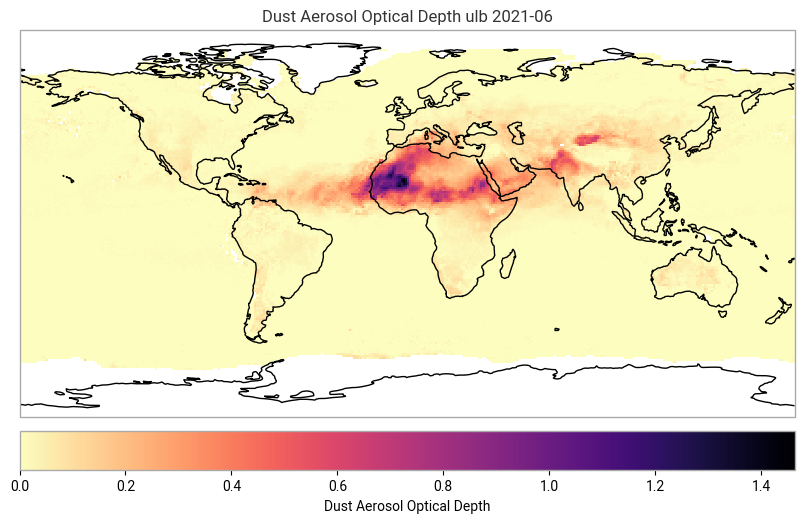

In [9]:
# Extract and plot the data
plot_date = "2021-06"
plot_da = ds[varname].sel(time=plot_date).squeeze()
variable_pretty = variable.title().replace("_", " ")

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection}, figsize=(10, 6))
# ax.set_global()
cax = ax.pcolormesh(
    plot_da.longitude, plot_da.latitude, plot_da, transform=ccrs.PlateCarree(), cmap='magma_r'
)
plt.colorbar(cax, orientation='horizontal', label=variable_pretty, fraction=0.1, pad=0.03)

ax.coastlines() # plot the coastlines
title = f"{variable_pretty} {algorithm} {plot_date}"
ax.set_title(title) # write title


# To save the figure, uncomment the following line
# plt.savefig(f'{DATADIR}/{title.replace(" ", "_")}.png', dpi=500, bbox_inches='tight') # save the plot file

plt.show()

**FIGURE 1:** You can see here a typical global aerosol map with well-known features (depending on season and variable) such as the spring Sahara dust outflow over the Atlantic (Dust AOD), the autumn biomass burning in Southern Africa and the Amazonas (Fine Mode AOD), and several more.

## Use case 2: Regional time series

After looking at one example of a monthly time averaged global distribution, in the next step we further investigate the dataset. The single sensor aerosol datasets are up to 15 years long, so that another useful way of visualizing is a time series. We will calculate a regional time series, plot it, and discuss its features.

First we will pick a region of interest to investigate. Below are common definitions for a set of areas with rather homogeneous aerosol properties and meaningful aerosol behaviour. We choose the `'Dust belt'` region for this anaylsis, you can choose to plot a different region, or define your own.

In [10]:
# Select region of interest
region = 'Dust belt'
# Definition of different regions to choose from
extent = {
    # 'Region' : [lon_min, lon_max, lat_min, lat_max],
    'Europe': [-15, 50, 36, 60],
    'Boreal': [-180, 180, 60, 85],
    'Asia_North': [50, 165, 40, 60],
    'Asia_East': [100, 130, 5, 41],
    'Asia_West': [50, 100, 5, 41],
    'China_South-East': [103, 135, 20, 41],
    'Australia': [100, 155, -45, -10],
    'Africa_North': [-17, 50, 12, 36], 
    'Africa_South': [-17, 50, -35, -12],
    'South_America': [-82, -35, -55, 5],
    'North_America_West': [-135, -100, 13, 60],
    'North_America_East': [-100, -55, 13, 60],
    'Indonesia': [90, 165, -10, 5],
    'Atlanti_Ocean_dust': [-47, -17, 5, 30],
    'Atlantic_Ocean_biomass_burnig': [-17, 9, -30, 5],
    'World': [-180, 180, -90, 90],
    'Asia': [50, 165, 5, 60],
    'North_America': [-135, -55, 13, 60], 
    'Dust belt': [-80, 120, 0, 40], 
    'India': [70, 90, 8, 32], 
    'Northern_Hemisphere': [-180, 180, 0, 90], 
    'Southern_Hemisphere': [-180, 180, -90, 0],
}

We can now select our region of interest and calculate the time series.

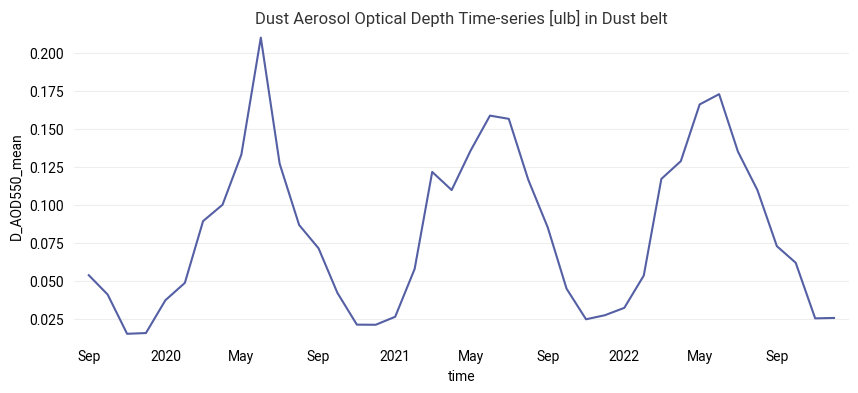

In [24]:
# Plot the time series
ds_region = ds.sel(
    latitude=slice(extent[region][2], extent[region][3]),
    longitude=slice(extent[region][0], extent[region][1])
)

plot_mean_data = ds_region[varname].mean(dim=['latitude', 'longitude'])  #, skipna=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_mean_data.plot(ax=ax)
ax.set_title(f"{variable_pretty} Time-series [{algorithm}] in {region}")
# # To save the figure, uncomment the following line
# plt.savefig(f'{DATADIR}/timeseries_{variable}_{algorithm}_{region}.png', dpi=500, bbox_inches='tight')

plt.show()

**FIGURE 2:** Such an aerosol time series typically shows a more or less obvious annual cycle related to the annual cycle of the relevant sources and meteorological conditions. In some years and regions exceptional peaks may be seen.

## Use case 3: "Climatology" (multi-annual mean) and anomaly - maps and time series

In the next step we further investigate the dataset by comparing the data of individual months to a longer-term mean state. We will use `earthkit-transforms` to calculate a monthly multi-annual mean and standard-deviation ("climatology").

To ensure sufficient sampling of the raw data, we will mask points which fall below our minimum sampling threshold. The code cell below uses earthkit `earthkit-transforms` to create a mask where a months falls below our minimum sampling threshold. As a demonstration, we plot the mask for January.

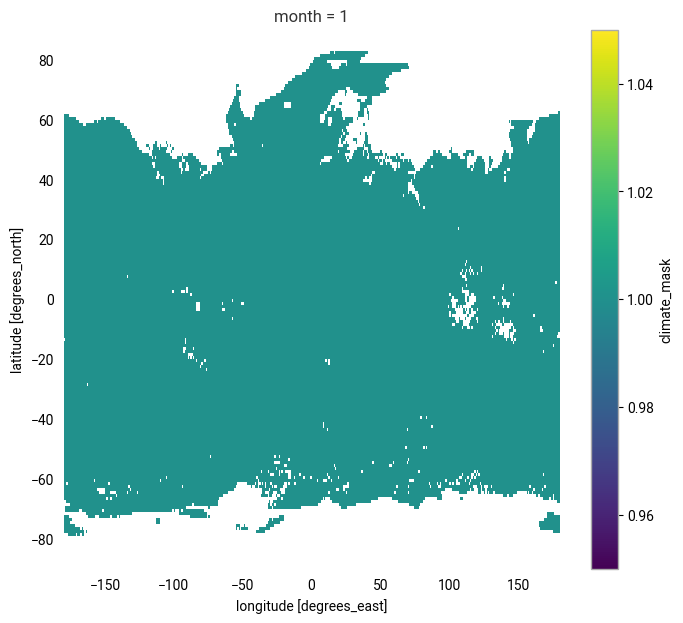

In [12]:
# Select the minimum number of years for a valid data point
min_years = 2

# Calculate the number of valid observations per month
obs_mask = xr.where(np.isnan(ds[varname]), 0, 1)
obs_climate = ek_aggregate.climatology.monthly_reduce(obs_mask, how="sum").rename("climate_mask")

# The mask is where a month has fewer datapoint than the minimum number of years
mask = xr.where(obs_climate > min_years, 1, np.nan)
mask.isel(month=0).plot()

Below we calculate the multi-year mean and standard-deviation. The mask is applied, and then they are merged into a single `xarray.Dataset`.

The output of the cell below shows our `xarray.Dataset` with the multi-year mean and standard deviation, note that the data now has the dimension `month`.

In [13]:
# Calculate the climatology mean and standard deviation
da_climate_mean = ek_aggregate.climatology.monthly_mean(ds[varname], how_label="mean")
da_climate_standard_deviation = ek_aggregate.climatology.monthly_std(ds[varname], how_label="std")

# Apply the mask to the data
da_climate_mean = da_climate_mean.where(mask, other=np.nan)
da_climate_standard_deviation = da_climate_standard_deviation.where(mask, other=np.nan)

# Merge into a single dataset
climate_mean_varname = da_climate_mean.name
climate_std_varname = da_climate_standard_deviation.name
ds_climate = xr.Dataset({
    da_climate_mean.name: da_climate_mean, 
    da_climate_standard_deviation.name: da_climate_standard_deviation
})
ds_climate


<xarray.Dataset> Size: 12MB
Dimensions:             (latitude: 180, longitude: 360, month: 12)
Coordinates:
  * latitude            (latitude) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * longitude           (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * month               (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    D_AOD550_mean_mean  (month, latitude, longitude) float64 6MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD550_mean_std   (month, latitude, longitude) float64 6MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

### Plot a climatology map for selected calendar month

We can now plot a map of the mean for January across all the years. If you wish to plot a different month simple change the month selection at the top of the next code cell.

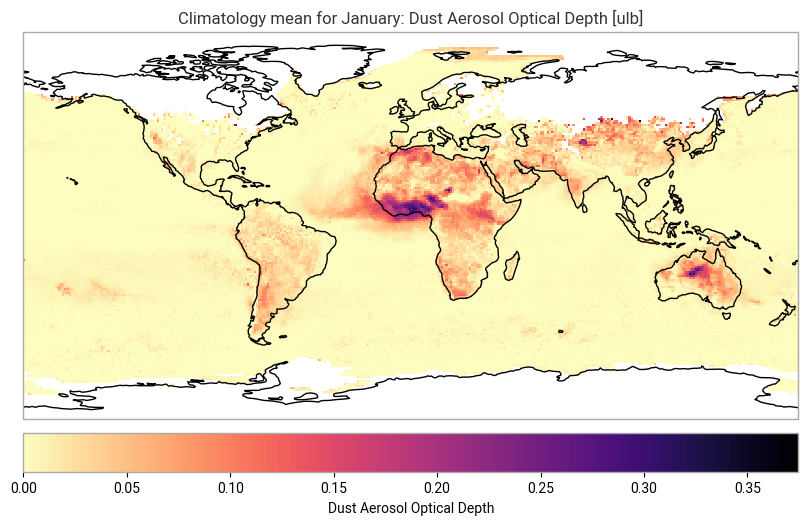

In [14]:
# Select one calendar month for a plot
month = 1
month_name = pd.to_datetime(month, format='%m').strftime('%B')

# Read the netCDF file
plot_da = ds_climate.sel(month=month)[climate_mean_varname]

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection}, figsize=(10, 6))
# ax.set_global()
cax = ax.pcolormesh(
    plot_da.longitude, plot_da.latitude, plot_da, transform=ccrs.PlateCarree(), cmap='magma_r'
)
plt.colorbar(cax, orientation='horizontal', label=variable_pretty, fraction=0.1, pad=0.03)

ax.coastlines() # plot the coastlines
title = f"Climatology mean for {month_name}: {variable_pretty} [{algorithm}]"
ax.set_title(title) # write title

# To save the figure, uncomment the following line
# plt.savefig(f'{DATADIR}/{title.replace(" ", "_").replace(":","")}.png', dpi=500, bbox_inches='tight') # save the plot file

plt.show()

**FIGURE 3:** This figure shows (similar to the example monthly mean map above) those typical aerosol features which occur in the selected calendar month, but now averaged over several years and thus showing a multi-annual mean state of the atmosphere in that calendar month.

### Regional climatology: calculate and plot as time series

For the region and variable as selected above and the full timerange used for the multi-annual mean, we calculate now regional averages of the climatology in each calendar month and of each invidual month in the time series. We also calculate the standard deviation for each calendar month as measure of the multi-annual variability.

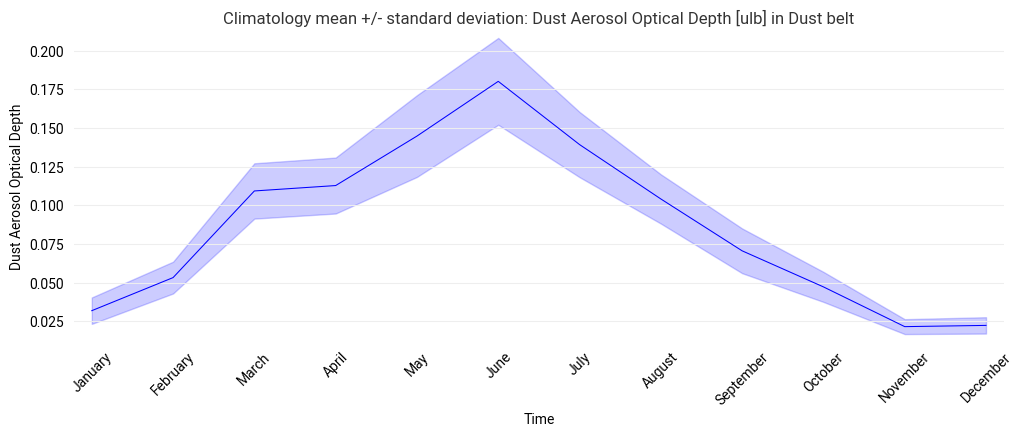

In [ ]:
# First we extract the region of interest
ds_climate_region = ds_climate.sel(
    latitude=slice(extent[region][2], extent[region][3]),
    longitude=slice(extent[region][0], extent[region][1])
)
# Then we calculate the spatial mean
plot_data = ds_climate_region.mean(dim=['latitude', 'longitude'])
plot_climate_mean_data = plot_data[climate_mean_varname]
plot_climate_std_data = plot_data[climate_std_varname]
month_strings = [pd.to_datetime(m, format='%m').strftime('%B') for m in plot_data.month.values]

fig, ax = plt.subplots(figsize=(12,4))

# Plot the climate mean +/- 0.5 standard deviations using fill_between
ax.fill_between(
    x=month_strings,
    y1=plot_climate_mean_data - (plot_climate_std_data*0.5),
    y2=plot_climate_mean_data + (plot_climate_std_data*0.5),
    color="blue", alpha=0.2,
)
# Plot the climatology and the mean time series
ax.plot(
    month_strings, plot_climate_mean_data,
    color="blue", linewidth=0.75,
)

ax.set_title(f"Climatology mean +/- standard deviation: {variable_pretty} [{algorithm}] in {region}")
ax.set_ylabel(f"{variable_pretty}")
ax.set_xlabel("Time")
ax.tick_params('x', rotation=45)

plt.show()


**FIGURE 4:** The figure shows the average annual cycle in the selected region extracted from the multi-annual dataset.

### Plot timeseries with climatology

Now we will plot the multi-annual time-series on top of the climatology mean +/- standard deviation. first we will resample our "climatology" DataArrays on to the time index of the original data.

In [16]:
months_index = plot_mean_data.time.dt.month
climate_mean_full_series = plot_climate_mean_data.sel(month=months_index).drop_vars("month")
climate_std_full_series = plot_climate_std_data.sel(month=months_index).drop_vars("month")


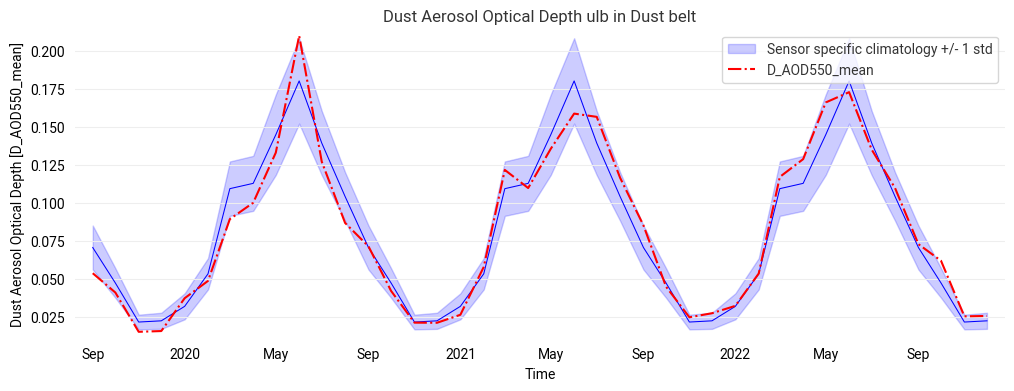

In [17]:
# Plot the time series overlayed with the annually repeated climatology
fig, ax = plt.subplots(figsize=(12,4))

# Plot the climate mean +/- 0.5 standard deviation using fill_between
ax.fill_between(
    x=climate_mean_full_series.time,
    y1=climate_mean_full_series - (climate_std_full_series*0.5),
    y2=climate_mean_full_series + (climate_std_full_series*0.5),
    color="blue", alpha=0.2, label="Sensor specific climatology +/- 1 std"
)
# Plot the climatology and the mean time series
climate_mean_full_series.plot(
    ax=ax, color="blue", linewidth=0.75,
    # label="Sensor specific climatology"
)

plot_mean_data.plot(ax=ax, label=varname, color="red", linestyle="-.")
ax.set_title(f"{variable_pretty} {algorithm} in {region}")
ax.set_ylabel(f"{variable_pretty} [{varname}]")
ax.set_xlabel("Time")
ax.legend()

plt.show()

**FIGURE 5:** The next figure shows the time series in red compared to the multiannual mean in blue and its standard deviation in light blue shading (both repeated from year to year). Exceptional episodes stand out if the red line breaks out of the blue shade.

### Anomaly time series

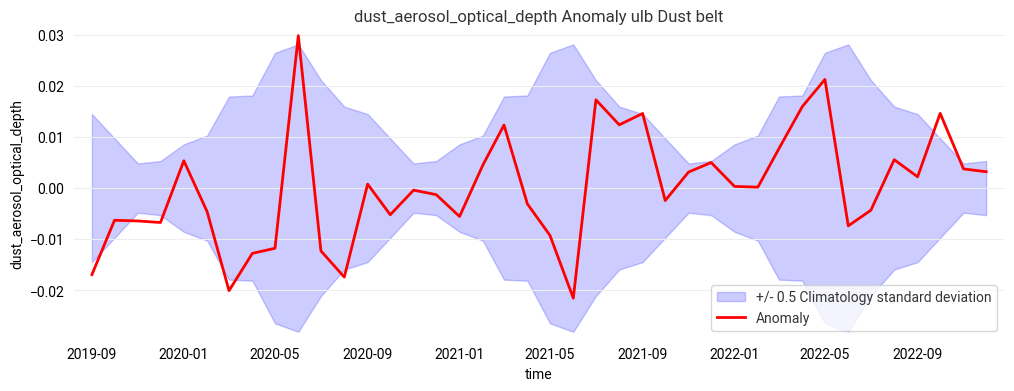

In [18]:
# Finally, we overplot the anomaly (= difference from the multi-annual averaged climatology) over the variability range of the data.
anomaly = plot_mean_data - climate_mean_full_series     
sdev_p = +0.5*climate_std_full_series
sdev_m = -0.5*climate_std_full_series

fig, ax = plt.subplots(figsize=(12,4))
plt.fill_between(plot_mean_data.time, sdev_p, sdev_m, color = 'blue', alpha = 0.2, label = '+/- 0.5 Climatology standard deviation')
plt.plot(plot_mean_data.time, anomaly, '-', label = 'Anomaly', color = 'red', linewidth = 2)
plt.ylabel(variable)
plt.xlabel('time')
plt.legend(loc='lower right') 
plt.title(variable + ' Anomaly ' + algorithm + ' ' + region)

# # To save the figure, uncomment the following line
# plt.savefig(f'{DATADIR}/anomaly_{variable}_{algorithm}_{region}.png', dpi=500, bbox_inches='tight')

plt.show()

**FIGURE 6:** This final regional time series plot shows the data record in the form of anomalies, i.e. differences between individual monthly data points and the multi-annual monthly mean compared to the multi-annual monthly variations around the zero anomaly line.

## Use Case 4: Visualize Vertical Profile data

As a last example we present a completely different dataset: vertical profiles obtained with the GOMOS star occultation spectrometer (Aergom algorithm).
For each observation the instrument needs to point to a star with sufficient brightness for the occultation measurement. Conceqeuntly, the observations are very sparse and not sufficient for daily mapping.
In response to user needs to allow identifying short-term and small-scale volcanic episodes, this dataset has a special temporal and spatial resolution: Temporally, it is provided as 5-daily averages (not as monthly or daily means). Spatially, it is provided for grid boxes of 60 degrees in longitude and 5 degrees in latitude since emissions from volcanic eruptions disperse along latitude bands in the stratosphere.
Consequently, the download sequence needs to query each calendar day to find and download the 5-daily files.

In [19]:
# Download GOMOS data: AERGOM algorithm, aerosol extinction profiles

# Define specific sub directory for the GOMOS data
GOMOS_DIR = os.path.join(DATADIR, 'GOMOS')
os.makedirs(GOMOS_DIR, exist_ok=True)

# Specify the characteristics of the data for downloading: variable, year(s), month(s), all days per month
# if you want to download the full data record, use the codes behind the #
# However, for downloading the entire 10 years of data with daily queries, the notebook will take a long time.
variable = 'aerosol_extinction_coefficient'
years = ['2008'] # years = ['%02d'%(year) for year in range('2002', '2012')]
months = ['07'] # months = ['%02d'%(month) for month in range(1, 13)]
days = ['%02d'%(day) for day in range(1, 32)]

# download the specified GOMOS data from the CDS
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)
dataset='satellite-aerosol-properties'
request = {
    'time_aggregation': '5_daily_composite',
    'variable': variable,
    'sensor_on_satellite': "gomos_on_envisat",
    'algorithm': "aergom",
    'year': years,
    'month': months,
    'day': days,
    'version': ["v4_01s"]
}
gomos_download_filename = f'{GOMOS_DIR}/aergom.zip'
if not os.path.exists(gomos_download_filename):
    print(f"Downloading GOMOS data")
    c.retrieve(dataset, request, gomos_download_filename)
else:
    print(f"File {gomos_download_filename} already exists, using that")


2025-03-25 16:33:57,983 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 16:33:57,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


File ./data_dir/GOMOS/aergom.zip already exists, using that


Extract the GOMOS data and open with xarray, in the same way we did for the previous data. The GOMOS data has a time dimension variable, so we do not need to manually add it as we did previosuly.

The `xarray.Dataset` output shows the data contained in the files. Note the `lev` dimension which is the altitude of the profile in units of km.

In [20]:
with zipfile.ZipFile(gomos_download_filename, 'r') as zip_ref:
    gomos_filelist = [os.path.join(GOMOS_DIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(GOMOS_DIR)

gomos_ds = xr.open_mfdataset(
    gomos_filelist,
    concat_dim="time",
    combine="nested",
)
gomos_ds

<xarray.Dataset> Size: 32MB
Dimensions:                          (time: 6, lat: 36, lon: 6, lev: 43)
Coordinates:
  * time                             (time) datetime64[ns] 48B 2008-07-05T12:...
  * lev                              (lev) float64 344B 8.0 9.0 ... 49.0 50.0
  * lat                              (lat) float64 288B -87.5 -82.5 ... 87.5
  * lon                              (lon) float64 48B -150.0 -90.0 ... 150.0
Data variables: (12/87)
    S_AOD355                         (time, lat, lon) float64 10kB dask.array<chunksize=(1, 36, 6), meta=np.ndarray>
    S_AOD355_uncertainty             (time, lat, lon) float64 10kB dask.array<chunksize=(1, 36, 6), meta=np.ndarray>
    S_AOD355_Ndata                   (time, lat, lon) float64 10kB dask.array<chunksize=(1, 36, 6), meta=np.ndarray>
    AEX355                           (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    AEX355_uncertainty               (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    AEX355_Ndata                     (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    ...                               ...
    VD_PSC                           (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    VD_PSC_uncertainty               (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    AEFF_PSC                         (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    AEFF_PSC_uncertainty             (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    ANG_PSC355-750-AEX               (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
    ANG_PSC355-750-AEX_uncertainty   (time, lev, lat, lon) float64 446kB dask.array<chunksize=(1, 43, 36, 6), meta=np.ndarray>
Attributes: (12/23)
    title:            GOMOS (AerGom) stratospheric aerosol retrieval level L3
    source:           Aerosol CCI
    institution:      Royal Belgian Institute for Space Aeronomy
    history:          Based on GOMOS product v6.01
    references:       ATBD can be found here: http://www.esa-aerosol-cci.org/...
    product_version:  4.01S
    ...               ...
    resolution:       5days time  x  1 km lev  x  5deg lat  x  60deg lon
    startDate:        2008/07/03
    endDate:          2008/07/07
    dateTime:         2008-07-05 12:00:00
    productID:        20080703-20080708-ESACCI-L3C_AEROSOL-AEX-GOMOS_ENVISAT-...
    inputFileList:    aergom_R33150_S0094_20080703_000005.nc
aergom_R33150_S0...

Plot a map at a choosen altitude and date.
For the AERGOM GOMOS vertical extinction profiles, you can select one vertical layer number and then plot a global map of this layer.

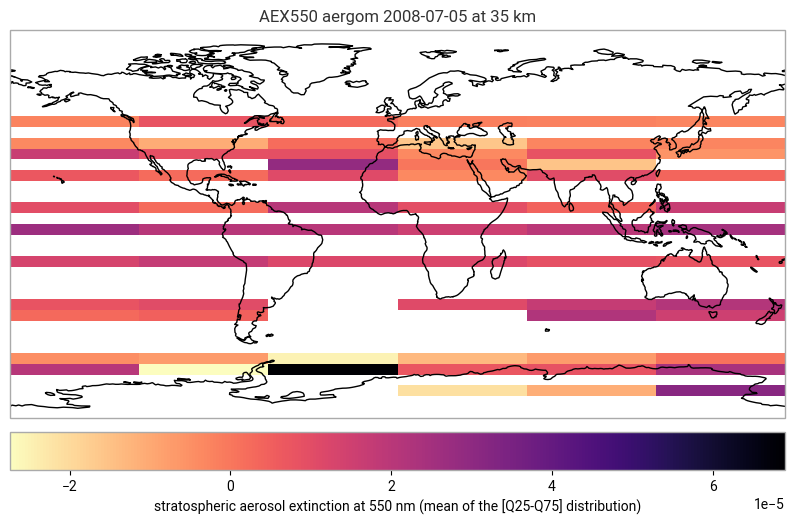

In [21]:
# select and plot the data: variable, layer number (= altitude in km)

variable = 'AEX550'
altitude = 35  # km
plot_date = "2008-07-05"

# extracts the choosen variable at the choosen altitude and date
plot_gomos_data = gomos_ds[variable].sel(lev=altitude, time=plot_date).squeeze()

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection}, figsize=(10, 6))
cax = ax.pcolormesh(
    plot_gomos_data.lon, plot_gomos_data.lat, plot_gomos_data, transform=ccrs.PlateCarree(), cmap='magma_r'
)
plt.colorbar(cax, orientation='horizontal', label=plot_gomos_data.attrs['long_name'], fraction=0.1, pad=0.03)
ax.coastlines() # plot the coastlines
title = f"{variable} aergom {plot_date} at {altitude} km"
plt.title(title)

# # To save the figure, uncomment the following line
# plt.savefig(f'{GOMOS_DIR}/{title.replace(" ", "_")}.png', dpi=500, bbox_inches='tight') # save the plot file

plt.show()

**FIGURE 7:** This map of aerosol extinction at the selected height layer illustrates the sparcity of the GOMOS data and the optzimized spatial grid (finer in latitudinal than in longitudinal dimension).

Finally, we plot an example vertical profile out of the dataset.

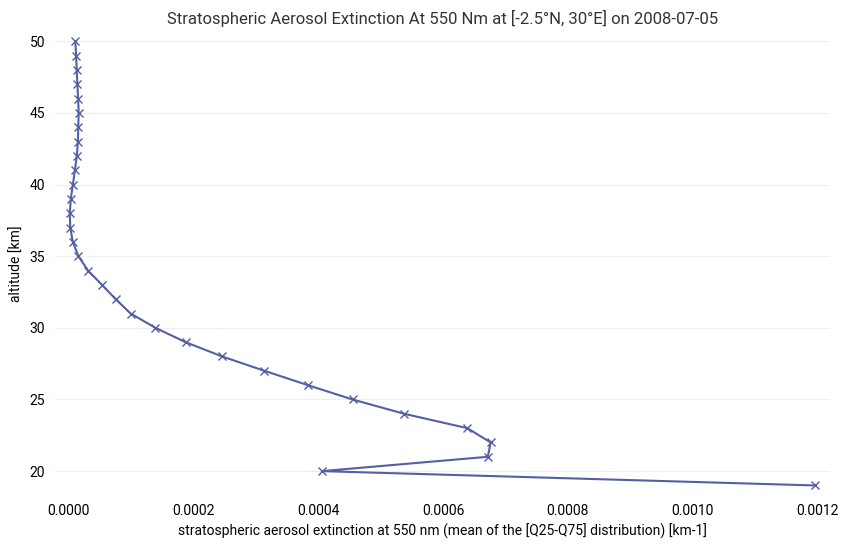

In [22]:
# Select the variable, date and lat/lon location to plot the vertical profile
latitude = -2.5
longitude = 30
variable = 'AEX550'
plot_date = "2008-07-05"

# extracts the data of the choosen variable from the dataset at the choosen location (lat, lon)
plot_gomos_data = gomos_ds[variable].sel(lat=latitude, lon=longitude, time=plot_date).squeeze()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_gomos_data.plot(y='lev', marker='x') # plot the profile
full_long_name = plot_gomos_data.attrs['long_name']
long_name = full_long_name.split(' (')[0].title()
ax.set_title(f"{long_name} at [{latitude}°N, {longitude}°E] on {plot_date}")
ax.set_xlabel(f"{plot_gomos_data.attrs['long_name']} [{plot_gomos_data.attrs['units']}]") # write x-axis label

# # To save the figure, uncomment the following line
# plt.savefig(f'{GOMOS_DIR}/vertical_profile{variable}_{latitude}_{longitude}_{plot_date}.png', dpi=500, bbox_inches='tight') # save the plot file

plt.show()

**FIGURE 8:** This plot of aerosol extinction at the selected location shows a vertical aerosol profile of the GOMOS data with differnet layers at 20 and 23 km altitude.

## Get more information about Aerosol properties and the Climate Data Store

- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

## References

[Product User Guide for CDS Aerosol Properties](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/AER/C3S2_312a_Lot2_PUGS_AER_latest.pdf)

[Thomas Popp, Gerrit de Leeuw, Christine Bingen, Christoph Brühl, Virginie Capelle, Alain Chedin, 
Lieven Clarisse, Oleg Dubovik, Roy Grainger, Jan Griesfeller, Andreas Heckel, Stefan Kinne, Lars Klüser, 
Miriam Kosmale, Pekka Kolmonen, Luca Lelli, Pavel Litvinov, Linlu Mei, Peter North, Simon Pinnock, 
Adam Povey, Charles Robert, Michael Schulz, Larisa Sogacheva, Kerstin Stebel, Deborah Stein Zweers, 
Gareth Thomas, Lieuwe Gijsbert Tilstra, Sophie Vandenbussche, Pepijn Veefkind, Marco Vountas and 
Yong Xue, Development, Production and Evaluation of Aerosol Climate Data Records from European 
Satellite Observations (Aerosol_cci), Remote Sensing, 8, 421; doi:10.3390/rs8050421, 2016](https://www.mdpi.com/2072-4292/8/5/421)